# Monocular Depth Estimation Using U-Net and MobileNetV3 on Jetson TX2 NX Devices

This model aims for monocular depth estimation using a U-Net architecture with a MobileNetV3 as the encoder. The model is trained on the DIODE Indoor Dataset.

The model are built using the pytorch and then will be converted to ONNX then to a TensorRT engine for inference on the Jetson TX2 NX device.

The model is trained using the Adam optimizer with a learning rate of 0.0001 (Can be changed). The model is trained using the mean squared error loss function.

For more information on the model, please refer to the following paper: https://arxiv.org/pdf/2004.04572.pdf

An Aditional information can be accessed in the following link: https://github.com/alinstein/Depth_estimation, https://www.kaggle.com/code/muhammadhafil/monocular-depth-estimation and https://www.kaggle.com/code/harits/indoor-depth-estimation-u-net

The dataset used for training can be found in the following link: https://diode-dataset.org/ or https://www.kaggle.com/datasets/soumikrakshit/nyu-depth-v2

In [1]:
conda install pytorch==1.12.1 torchvision==0.13.1 torchaudio==0.12.1 cudatoolkit=10.2 -c pytorch


Note: you may need to restart the kernel to use updated packages.



EnvironmentLocationNotFound: Not a conda environment: d:\Github



In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Torch Models (MobileNetV3 Pretrained)
from torchvision.models import mobilenet_v3_small

# warnings
import warnings
warnings.filterwarnings("ignore")

# sklearn
from sklearn.model_selection import train_test_split

# Class
from DiodeLoader import DataGenerator

In [3]:
# Check for how many GPUs are available
print("GPU Available: ", torch.cuda.is_available())
print("Number of GPUs: ", torch.cuda.device_count())

GPU Available:  True
Number of GPUs:  1


In [4]:
torch.zeros(1).cuda()

tensor([0.], device='cuda:0')

# Hyperparameters

In [5]:
# Hyperparameters
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001
INPUT_SIZE = 224
HEIGHT = 192
WIDTH = 256
MAX_DEPTH = 50.
MODEL = mobilenet_v3_small(pretrained=True)

print(MODEL)

MobileNetV3(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride

# Dataset Preparation

In [6]:
indoor_path = "./data/val/indoors"

file_list = []

for root, dirs, files in os.walk(indoor_path):
    for file in files:
        file_list.append(os.path.join(root, file))

file_list.sort()

data = {
    "image" : [x for x in file_list if x.endswith(".png")],
    "depth" : [x for x in file_list if x.endswith("_depth.npy")],
    "mask" : [x for x in file_list if x.endswith("_depth_mask.npy")]
}

df = pd.DataFrame(data)
df = df.sample(frac=1, random_state=42)
df.head()


,image,depth,mask
234,./data/val/indoors\scene_00021\scan_00188\0002...,./data/val/indoors\scene_00021\scan_00188\0002...,./data/val/indoors\scene_00021\scan_00188\0002...
110,./data/val/indoors\scene_00020\scan_00185\0002...,./data/val/indoors\scene_00020\scan_00185\0002...,./data/val/indoors\scene_00020\scan_00185\0002...
248,./data/val/indoors\scene_00021\scan_00189\0002...,./data/val/indoors\scene_00021\scan_00189\0002...,./data/val/indoors\scene_00021\scan_00189\0002...
9,./data/val/indoors\scene_00019\scan_00183\0001...,./data/val/indoors\scene_00019\scan_00183\0001...,./data/val/indoors\scene_00019\scan_00183\0001...
93,./data/val/indoors\scene_00020\scan_00184\0002...,./data/val/indoors\scene_00020\scan_00184\0002...,./data/val/indoors\scene_00020\scan_00184\0002...


# Visualize the Depth Map

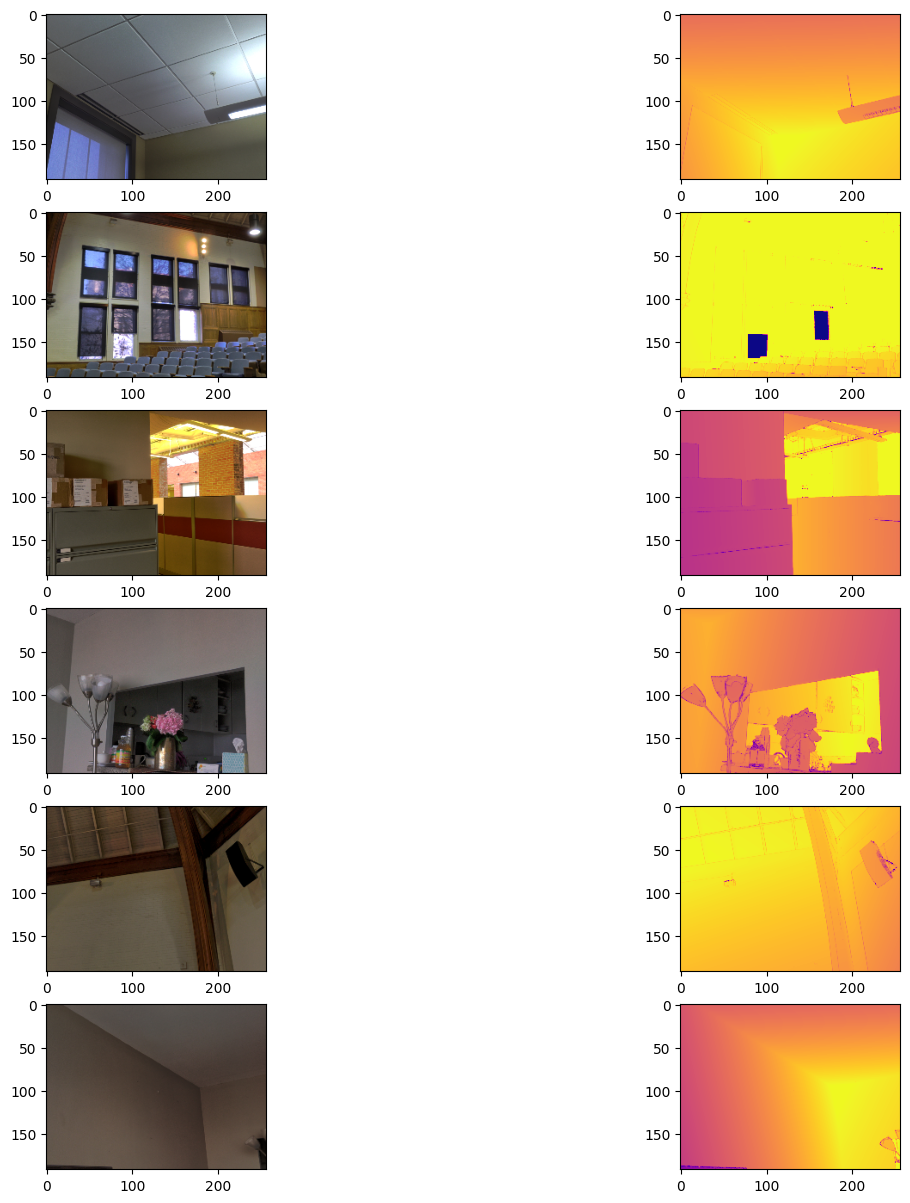

In [11]:
# Load the dataset
def visualize_depth_map(samples, test=False, model=None):
    input, target = samples
    cmap = plt.cm.plasma
    cmap.set_bad(color="black")

    if test:
        pred = model.predict(input)
        fig, ax = plt.subplots(6, 3, figsize=(50, 50))
        for i in range(6):
            ax[i, 0].imshow((input[i].squeeze()))
            ax[i, 1].imshow((target[i].squeeze()), cmap=cmap)
            ax[i, 2].imshow((pred[i].squeeze()), cmap=cmap)

    else:
        fig, ax = plt.subplots(6, 2, figsize=(15, 15))
        for i in range(6):
            ax[i, 0].imshow((input[i].squeeze()))
            ax[i, 1].imshow((target[i].squeeze()), cmap=cmap)


visualize_samples = next(
    iter(DataGenerator(data=df, batch_size=6))
)
visualize_depth_map(visualize_samples)